In [1]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *
import IPython

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
MODEL_SAVE_PATH = 'whole_gen_10_after_words_attention_no_embd'

In [4]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [5]:
# all_data = pickle.load(open("data/en_train_fixed_4_sentences.pkl", "rb" ))
all_data = pickle.load(open("data/en_train_fixed_5_manual.pkl", "rb" ))
# all_data_sentence_index = all_data.set_index('sentence_id')

In [6]:
sample_data = all_data.copy()
sample_data = sample_data[sample_data['class'] != 'NOT_CHANGED']
sample_data = sample_data[sample_data['class'] != 'MANUAL']
print("Data rows: {},  (dropped rows: {})".format(len(sample_data), len(all_data)-len(sample_data)))
sample_data = sample_data.reset_index(drop=True)
del(all_data)

Data rows: 654333,  (dropped rows: 9263859)


In [7]:
categories_all = sorted(sample_data["class"].unique())
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['ELECTRONIC', 'LETTERS', 'NUMBERS', 'PLAIN', 'VERBATIM']
5


### Utils stuff

In [8]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


common_words, common_words_index = load_common_words_10k()
len(common_words)
common_words[0:10]

In [9]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

### After words handling

In [10]:
words_after_common = pickle.load(open("data/en_features/words_after_ext.pkl", 'rb'))
words_after_index = dict((c, i) for i, c in enumerate(words_after_common))
words_after_common[0:7]
len(words_after_common)

['<EOS>', '<SOS>', '<UNK>', '<0000>', '<SAMPLE>', 'two', 'twenty']

1351

In [11]:
sos_tensor = torch.zeros(1, 1, len(words_after_index))
sos_tensor[0, 0, words_after_index[SOS_TOKEN]] = 1
sos_tensor.size()
#del(onehot_sos)

# sos_tensor = torch.LongTensor([words_after_index[SOS_TOKEN]])

torch.Size([1, 1, 1351])

### More balanced sample

In [236]:
balanced_data_classes_select = list(sample_data.groupby('class'))

balanced_data_accessed_counter = 0 
balanced_data_randomize_freq = False
balanced_data_length = 0

def balanced_data_randomize_org(max_len=20000):
    global balanced_data, balanced_data_length, balanced_data_accessed_counter, balanced_data_randomize_freq
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])
    balanced_data_length = len(balanced_data)
    balanced_data_randomize_freq = balanced_data_length * 0.2
    balanced_data_accessed_counter = 0
balanced_data_randomize = balanced_data_randomize_org

def balanced_data_sample_row():
    global balanced_data_accessed_counter
    global balanced_data_last_sample
    balanced_data_accessed_counter += 1
    if balanced_data_randomize_freq and balanced_data_accessed_counter > balanced_data_randomize_freq:
        balanced_data_randomize()
    balanced_data_last_sample = balanced_data.iloc[random.randint(1, balanced_data_length-1)]
    return balanced_data_last_sample
    
balanced_data_randomize()

In [13]:
#all_data.groupby('class')['class'].count()
#sample_data.groupby('class')['class'].count()
balanced_data.groupby('class')['class'].count()

class
ELECTRONIC     4964
LETTERS       20000
NUMBERS       20000
PLAIN         20000
VERBATIM      11741
Name: class, dtype: int64

In [94]:
balanced_data_sample_row()

sentence_id                                                66440
token_id                                                      12
class                                                      PLAIN
before                                                        sq
after                                                     square
class_org                                                  PLAIN
a_word_ind                                              [106, 0]
sentence       there were 3 , 942 housing units at an average...
Name: 57557, dtype: object

### Samples

In [15]:
def get_random_sample():
    sample_row = balanced_data_sample_row()   
    return sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence']
            
def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    s_aft_str = ' '.join([words_after_common[i] for i in s_aft])
    print(s_class, ':', s_bef, '->', s_aft_str, s_aft)
    print(s_sentence)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
tmp()

LETTERS : NOTCH -> n o t c h <EOS> [29, 25, 30, 21, 45, 0]
lck has been shown to interact with : adam 15 , cd 2 , cd 44 , cd 4 , coup tfii , dlg 1 , <SAMPLE> 1 , pik 3 ca , ptpn 6 , ptprc , unc 119 , syk , ube 3 a , andzap 70 .
torch.Size([1, 6, 104])


In [16]:
%%timeit
get_random_sample()

163 µs ± 2.04 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Model functions

In [17]:
use_cuda = True

In [18]:
tmp = sample_data[sample_data['before'].str.len()>50]
len(tmp)
tmp.sample(2)
tmp[~tmp['before'].str.contains('/')].sample(2)

499

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
240278,276093,2,ELECTRONIC,http://www.rollingstone.com/music/albumreviews...,h t t p colon slash slash w w w dot r o l l i ...,ELECTRONIC,"[45, 30, 30, 24, 129, 101, 101, 52, 52, 52, 74...",rolling stone <SAMPLE> .
340543,392314,17,ELECTRONIC,https://diva.sfsu.edu/collections/sfbatv/bundl...,h t t p s colon slash slash d i v a dot s f s ...,ELECTRONIC,"[45, 30, 30, 24, 17, 129, 101, 101, 26, 31, 54...",watch the full 60 minute version of this 1973 ...


,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
593100,678277,4,NUMBERS,06-09-05 GEN RE EXECUTIVE JOHN HOULDSWORTH PLE...,o six sil o nine sil o five sil gen sil re sil...,TELEPHONE,"[25, 20, 58, 25, 15, 58, 25, 14, 58, 1303, 58,...",""" # 314 : <SAMPLE> , agrees to cooperate with ..."
279519,321586,1,ELECTRONIC,0-253-34237-6wpamurals.comlibrary.wustl.eduAdr...,o d a s h t w o f i v e t h r e e d a s h t h ...,ELECTRONIC,"[25, 26, 22, 17, 45, 30, 52, 25, 37, 31, 54, 2...","isbn <SAMPLE> drell , chicago sun times , 21 j..."


In [19]:
MAX_ATTENTION_LENGTH = 50

### Encoder

In [20]:
class EncoderRNN(nn.Module):
    def __init__(self, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_layers=1, chars_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size
        self.hidden_size = words_hidden_size + chars_hidden_size

        self.rnn_words = nn.LSTM(words_input_size, words_hidden_size // 2, words_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.LSTM(chars_input_size, chars_hidden_size // 2, chars_layers,
                                batch_first=True, bidirectional=True)
        
    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        hidden_states_cat = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.hidden_size)).cuda()
        for ei in range(min(MAX_ATTENTION_LENGTH, len(string_tensor[0]))):
            hidden_states_cat[ei] = torch.cat((output_words, all_outputs_chars[0, ei].view(1,-1)), 1)
                
        output = torch.cat((output_words[0], output_chars[0]), 0)

        #output = torch.cat((output_words, output_chars), 1)
        
        #return output, all_outputs_chars
        return output, hidden_states_cat

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var1_2 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2_1 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var2_2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        
        var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
        var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))
    
    
encoder_rnn = EncoderRNN(words_input_size=wv_vecs.shape[-1], chars_input_size=len(chars_normal),
                         words_hidden_size=128, chars_hidden_size=256,
                         words_layers=1, chars_layers=1).cuda()
encoder_rnn


EncoderRNN (
  (rnn_words): LSTM(50, 64, batch_first=True, bidirectional=True)
  (rnn_chars): LSTM(104, 128, batch_first=True, bidirectional=True)
)

In [21]:
def test_encoder_single_sample():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    print(s_bef)
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    return encoder_rnn(words_t, string_t), s_bef
    
(encoder_output, encoder_outputs), tmp = test_encoder_single_sample()
tmp
encoder_output.size()
encoder_outputs.size()
torch.eq(encoder_output, encoder_outputs[len(tmp)]).data.all()

T-


'T-'

torch.Size([384])

torch.Size([50, 384])

True

### Decoder

In [22]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout_p=0.1, max_length=MAX_ATTENTION_LENGTH):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        #self.rnn = nn.GRU(input_size, hidden_size, n_layers,
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers,
                                 batch_first=True, bidirectional=False)
        
        self.lin_out = nn.Linear(hidden_size, input_size)
        #self.softmax = nn.LogSoftmax()
        
        #self.embedding = nn.Embedding(input_size, hidden_size)
        self.emb_lin = nn.Linear(input_size, hidden_size)
        self.max_length = max_length
        self.attn = nn.Linear(hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        
    #def forward(self, char, hidden):
    def forward(self, last_input, hidden, encoder_outputs):
        #embedded = self.embedding(last_input).view(1, 1, -1)
        embedded = self.emb_lin(last_input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        #IPython.core.debugger.Pdb().set_trace()
        #attn_weights = F.softmax(self.attn(torch.cat((char[0], hidden[0]), 1)))
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.lin_out(output[0]))
        return output, hidden, attn_weights
    
    def init_rest_hidden(self, input_var):
        if self.n_layers > 1:
            hid_var = Variable(torch.zeros(self.n_layers - 1, 1, self.hidden_size)).cuda()
            res = torch.cat((input_var, hid_var), 0)
            return res
        else:
            return input_var
        

decoder_rnn = DecoderRNN(input_size=len(words_after_common), hidden_size=encoder_output.size()[0], n_layers=1)
decoder_rnn = decoder_rnn.cuda()
decoder_rnn

tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]

DecoderRNN (
  (rnn): GRU(384, 384, batch_first=True)
  (lin_out): Linear (384 -> 1351)
  (emb_lin): Linear (1351 -> 384)
  (attn): Linear (768 -> 50)
  (attn_combine): Linear (768 -> 384)
  (dropout): Dropout (p = 0.1)
)

[torch.Size([1, 1351]), torch.Size([1, 1, 384]), torch.Size([1, 50])]

In [23]:
torch.bmm(torch.FloatTensor([1,0.1,0.1]).view(1,1,-1), torch.arange(0, 12).view(1,3,-1))


(0 ,.,.) = 
  1.2000  2.4000  3.6000  4.8000
[torch.FloatTensor of size 1x1x4]

In [24]:
tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]
print(tmp[0].topk(1)[1])
print(words_after_common[tmp[0].topk(1)[1].data[0][0]])

[torch.Size([1, 1351]), torch.Size([1, 1, 384]), torch.Size([1, 50])]

Variable containing:
 434
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

pence


# Training etc

### Accuracy

In [76]:
def test_model_single_sample(model=None, return_more=False, sample=False):
    decoder_rnn.eval()
    encoder_rnn.eval()
    
    if not sample:
        sample = get_random_sample()
    s_bef, s_aft, s_class, s_sentence = sample
        
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()

    decoded_output = []
    decoder_attns_arr = []
    max_length = 20
    for _ in range(max_length):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attns_arr.append(decoder_attns)
        #return decoder_output

        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
                
        if word == EOS_TOKEN:
            break

        decoded_output.append(word)
        
        #decoder_input = Variable(torch.LongTensor([word_index])).cuda()
        
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
    
    output = ' '.join(decoded_output)
    sample_target = ' '.join([words_after_common[w] for w in s_aft][:-1])
    
    decoder_rnn.train()
    encoder_rnn.train()
    
    if return_more:
        return output, decoded_output, decoder_attns_arr, sample
    
    return output, output, sample_target, sample
    
tmp = test_model_single_sample(None)
tmp

('december twenty eleven',
 'december twenty eleven',
 'december twenty eleven',
 ('December 2011',
  [65, 6, 48, 0],
  'NUMBERS',
  'beting , gianfranco ( <SAMPLE> ) , " pantanal : o ultimo voo do tuiuiu " , flap internacional ( in portuguese ) ( 472 ) : 46 .'))

In [26]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(None, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft, s_class, s_sentence = sample
        print("{:<14} => {:<14} || {} \n{:>17} {}".format(s_bef, predict, s_aft, '', s_sentence, ))
print_local_wrong_predictions(2)

25 January 2010 => visualized categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization || [11, 6, 78, 12, 63, 6, 44, 0] 
                  <SAMPLE> .
labour         => pence categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization categorization || [137, 0] 
                  some new prisoners were selected to work as slave <SAMPLE> , but most went straight to the gas chamber .


In [27]:
%%time
test_model_accuracy(encoder_rnn, test_model_single_sample, n_sample=100)

Accuracy: 0.00% (       0/     100)
CPU times: user 2.48 s, sys: 40 ms, total: 2.52 s
Wall time: 2.52 s


0.0

### Training

In [28]:
def train(s_bef, s_aft, s_sentence, encoder_optimizer, decoder_optimizer, loss_function,
          use_teacher_forcing, max_length=20):
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()
    
    ###
    target_arr = s_aft
    #target_arr = after_sentence_to_word_indexes(s_aft, include_eos=True)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0
    
    decoded_output = []
    for i in range(len(target_arr)):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)

        #decoder_target_i = chars_after_index[target_arr[i]]
        decoder_target_i = target_arr[i]
        decoder_target_i = Variable(torch.LongTensor([decoder_target_i])).cuda()
        loss += loss_function(decoder_output, decoder_target_i)
        
        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
        decoded_output.append(word)
        
        if use_teacher_forcing:
            word_index = target_arr[i] # replace input with right target
        else:
            # use output normally as input 
            if word == EOS_TOKEN:
                break
                
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
        #decoder_input = Variable(torch.LongTensor([word_index])).cuda()
        
    if decoded_output[-1] == EOS_TOKEN:
        decoded_output = decoded_output[:-1]
        
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return ' '.join(decoded_output), (loss.data[0] / len(target_arr))


In [184]:
def train_iterations(n_iters=100000, lr=0.001, teacher_forcing_ratio=0.5,
                     print_every=10000, plot_every=1000):

    start = time.time()
    
    decoder_rnn.train()
    encoder_rnn.train()

    current_loss = 0
    current_loss_iter = 0

    encoder_optimizer = torch.optim.Adam(encoder_rnn.parameters(), lr=lr)
    decoder_optimizer = torch.optim.Adam(decoder_rnn.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        use_teacher_forcing = random.random() < teacher_forcing_ratio
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(s_bef=s_bef, s_aft=s_aft, s_sentence=s_sentence,
                             encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer,
                             loss_function=nn.NLLLoss(), use_teacher_forcing=use_teacher_forcing,
                             max_length=40 )
        
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            teacher_forcing_str = ""
            if use_teacher_forcing:
                teacher_forcing_str = "(forcing)"
            s_aft_sentence = ' '.join([words_after_common[w] for w in s_aft][:-1])
            correct = '✓' if result == s_aft_sentence else "✗: {}".format(s_aft_sentence)
            
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({}) {}".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, result, correct, teacher_forcing_str))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0 or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(encoder_rnn, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [30]:
model_training = ModelTraining(MODEL_SAVE_PATH, [encoder_rnn, decoder_rnn])

Save path: data/models/whole_gen_10_after_words_attention_no_embd


In [31]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

     9  18% (   0m 0s)   7.178   |   7.16: 10 -> visualized (✗: [44, 0]) 
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/10_(EncoderRNN/DecoderRNN)
Accuracy: 0.00% (       0/   10000)
    18  36% (   1m 2s)   5.897   |   1.80: MCC ->  (✗: [32, 21, 21, 0]) 
    27  54% (   1m 3s)   5.220   |   7.07: vol -> <EOS> (✗: [107, 0]) (forcing)
    36  72% (   1m 3s)   4.725   |   7.12: FGF -> <EOS> <EOS> <EOS> (✗: [37, 53, 37, 0]) (forcing)
    45  90% (   1m 3s)   4.734   |   7.08: FC -> <EOS> <EOS> (✗: [37, 21, 0]) (forcing)


In [32]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   550  53% (   0m 8s)   3.357   |   4.56: mobilisation ->  (✗: [574, 0]) 


In [33]:
train_iterations(n_iters=9000, lr=0.0001, print_every=1000)

  2000  11% (  0m 21s)   2.669   |   1.20: 19 November 2003 -> the (✗: [11, 87, 12, 69, 5, 8, 13, 0]) 
  3000  22% (  0m 41s)   2.473   |   2.99: AK -> nineteen <EOS> (✗: [22, 59, 0]) (forcing)
  4000  33% (   1m 0s)   2.374   |   2.05: st -> nineteen (✗: [102, 0]) 
  5000  44% (  1m 22s)   2.402   |   2.89: Overstock.com -> s s a a c c c c c <EOS> c c c (✗: [25, 54, 28, 35, 17, 30, 25, 21, 59, 74, 21, 25, 32, 0]) (forcing)
  6000  56% (  1m 43s)   2.194   |   0.23: & -> and (✓) 
  7000  67% (   2m 3s)   2.038   |   1.86: 1987 -> nineteen thousand (✗: [7, 27, 18, 0]) 
  8000  78% (  2m 27s)   1.982   |   1.09: # -> to (✗: [109, 0]) 
  9000  89% (  2m 50s)   1.919   |   3.01: 525 -> nineteen hundred six (✗: [14, 10, 6, 14, 0]) 
 10000 100% (  3m 15s)   1.855   |   2.35: pci -> m s (✗: [24, 21, 31, 0]) 


In [34]:
train_iterations(n_iters=90000, print_every=10000)

 20000  11% (  3m 30s)   1.154   |   0.00: & -> and (✓) (forcing)
 30000  22% (  7m 18s)   0.680   |   0.13: 1973 -> nineteen seventy three (✓) (forcing)
 40000  33% (  11m 1s)   0.652   |   0.92: E&M -> e m m (✗: [28, 55, 32, 0]) (forcing)
 50000  44% ( 14m 41s)   0.537   |   0.00: J. -> j (✓) 
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/50000_(EncoderRNN/DecoderRNN)
Accuracy: 72.18% (    7218/   10000)
 60000  56% ( 19m 46s)   0.565   |   0.00: 5 -> five (✓) (forcing)
 70000  67% ( 23m 24s)   0.517   |   0.03: st -> saint (✓) 
 80000  78% ( 27m 13s)   0.406   |   0.05: 29 -> twenty nine (✓) (forcing)
 90000  89% ( 30m 54s)   0.389   |   0.00: pp -> p p (✓) (forcing)
100000 100% ( 34m 42s)   0.435   |   0.00: - -> to (✓) 
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/100000_(EncoderRNN/DecoderRNN)
Accuracy: 76.11% (    7611/   10000)


In [35]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.001)

110000   5% (  3m 48s)   0.463   |   0.01: st -> saint (✓) 
120000  10% (  7m 32s)   0.409   |   0.01: franchise -> franchize (✓) (forcing)
130000  15% ( 11m 21s)   0.342   |   0.00: & -> and (✓) 
140000  20% ( 15m 10s)   0.398   |   1.59: 200852 -> twenty hundred fifty two <EOS> fifty two (✗: [5, 10, 8, 16, 10, 38, 5, 0]) (forcing)
150000  25% ( 18m 53s)   0.419   |   0.00: centre -> center (✓) 
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/150000_(EncoderRNN/DecoderRNN)
Accuracy: 81.72% (    8172/   10000)
160000  30% ( 23m 58s)   0.374   |   1.60: CMYK -> c y y <EOS> (✗: [21, 32, 86, 59, 0]) (forcing)
170000  35% ( 27m 51s)   0.357   |   1.37: Kordia.co.nz -> k o n n a n dot c o dot o z (✗: [59, 25, 35, 26, 31, 22, 74, 21, 25, 74, 29, 105, 0]) (forcing)
180000  40% ( 31m 33s)   0.410   |   0.00: 1960 -> nineteen sixty (✓) (forcing)
190000  45% ( 35m 16s)   0.417   |   0.01: theatre -> theater (✓) (forcing)
200000  50% ( 38m 59s)   0.333   |   3.06: stabilised

In [36]:
print_local_wrong_predictions()

Billboard.biz  => b i l l b i b b dot dot i b || [36, 31, 42, 42, 36, 25, 22, 35, 26, 74, 36, 31, 105, 0] 
                  <SAMPLE> ( april 19 , 2014 ) .
obec           => o b e e        || [25, 36, 28, 21, 0] 
                  chvalnov lisky is a village and municipality ( <SAMPLE> ) in kromeriz district in the zlin region of the czech republic .
January 13, 1973 => january thirteenth nineteen seventy three three || [63, 100, 7, 33, 13, 0] 
                  cristian heyne ( born <SAMPLE> in santiago ) is a chilean composer and producer , and formally a journalist .
mineralisation => modernization  || [864, 0] 
                  the ore therefore belongs to the <SAMPLE> type sphalerite pyrite galena chalcopyrite .
Fotbolls-em.nu => f o l b b b e s s dot s t || [37, 25, 30, 36, 25, 42, 42, 17, 26, 22, 17, 45, 28, 32, 74, 29, 43, 0] 
                  <SAMPLE> ( in swedish ) .
67th           => sixty seven    || [39, 82, 0] 
                  the <SAMPLE> je khenpo , ngawang thinley 

In [37]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.3, lr=0.001)

310000   5% (  3m 51s)   0.376   |   0.04: FX -> f x (✓) (forcing)
320000  10% (  7m 33s)   0.324   |   0.00: NFL -> n f l (✓) 
330000  15% ( 11m 19s)   0.332   |   0.00: Prologue -> prolog (✓) 
340000  20% (  15m 7s)   0.347   |   0.00: Theatre -> theater (✓) (forcing)
350000  25% (  19m 2s)   0.340   |   0.00: 5 -> five (✓) (forcing)
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/350000_(EncoderRNN/DecoderRNN)
Accuracy: 85.02% (    8502/   10000)
360000  30% (  24m 1s)   0.302   |   0.00: FG -> f g (✓) 
370000  35% ( 27m 51s)   0.319   |   0.01: specialising -> specializing (✓) 
380000  40% ( 31m 41s)   0.349   |   1.04: Billboard.com -> b i o l b dot dot a (✗: [36, 31, 42, 42, 36, 25, 22, 35, 26, 74, 21, 25, 32, 0]) 
390000  45% ( 35m 20s)   0.266   |   1.56: lahistory.org -> l a s a t h y r g dot dot r g g (✗: [42, 22, 45, 31, 17, 30, 25, 35, 86, 74, 25, 35, 53, 0]) (forcing)
400000  50% ( 39m 17s)   0.300   |   0.00: 1992 -> nineteen ninety two (✓) 
Saved mo

In [38]:
print_local_wrong_predictions()

2009-04-08     => the eighth of april two thousand eight || [11, 80, 12, 71, 5, 8, 15, 0] 
                  untalan , catherine ( <SAMPLE> ) .
www.theinquirer.net/inquirer/news/2331280/nokia-imaging-sdk-set-for-android-nokia-x-platform => w w w dot s s s s s s s s s s s s s s s s || [52, 52, 52, 74, 30, 45, 28, 31, 29, 111, 43, 31, 35, 28, 35, 74, 29, 28, 30, 17, 42, 22, 17, 45, 31, 29, 111, 43, 31, 35, 28, 35, 17, 42, 22, 17, 45, 29, 28, 52, 17, 17, 42, 22, 17, 45, 30, 52, 25, 30, 45, 35, 28, 28, 30, 45, 35, 28, 28, 25, 29, 28, 30, 52, 25, 28, 31, 53, 45, 30, 25, 17, 42, 22, 17, 45, 29, 25, 59, 31, 22, 26, 22, 17, 45, 31, 32, 22, 53, 31, 29, 53, 26, 22, 17, 45, 17, 26, 59, 26, 22, 17, 45, 17, 28, 30, 26, 22, 17, 45, 37, 25, 35, 26, 22, 17, 45, 22, 29, 26, 35, 25, 31, 26, 26, 22, 17, 45, 29, 25, 59, 31, 22, 26, 22, 17, 45, 97, 26, 22, 17, 45, 24, 42, 22, 30, 37, 25, 35, 32, 0] 
                  ux checklist — nokia x design guidelines http : / / <SAMPLE> " announcement of software up

In [39]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.0001)

510000  10% (  3m 50s)   0.250   |   0.00: LPs -> l p's (✓) 
520000  20% (  7m 35s)   0.256   |   0.00: _ -> underscore (✓) 
530000  30% ( 11m 20s)   0.249   |   0.00: 350 -> three hundred fifty (✓) 
540000  40% ( 15m 19s)   0.251   |   0.00: - -> to (✓) (forcing)
550000  50% (  19m 7s)   0.245   |   0.02: Chr -> c h r (✓) 
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/550000_(EncoderRNN/DecoderRNN)
Accuracy: 88.27% (    8827/   10000)
560000  60% ( 24m 11s)   0.212   |   0.00: ltd -> limited (✓) (forcing)
570000  70% ( 27m 56s)   0.254   |   0.00: LLC -> l l c (✓) 
580000  80% ( 31m 53s)   0.208   |   0.01: February 23, 2003 -> february twenty third two thousand three (✓) (forcing)
590000  90% ( 35m 34s)   0.221   |   0.00: U.S. -> u s (✓) 
600000 100% ( 39m 24s)   0.209   |   0.00: November 18, 2014 -> november eighteenth twenty fourteen (✓) 
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/600000_(EncoderRNN/DecoderRNN)
Accuracy: 88.75% (

In [40]:
print_local_wrong_predictions()

st             => saint          || [195, 0] 
                  new york : <SAMPLE> martin 's griffin , 1999 .
Brno           => b r n n        || [36, 35, 29, 25, 0] 
                  in 2006 sor introduced in <SAMPLE> on autotec a completely new range of low floor buses .
6.8 lbs        => six point eight nine || [20, 46, 16, 124, 0] 
                  released online on july 16 , 2009 , the inspiron 1750 is dell 's 17 . 3 " budget laptop that weighs <SAMPLE> .
Sports-Reference.com => s p o r t s d e s s e e e e e e e e dot c || [17, 24, 25, 35, 30, 17, 26, 22, 17, 45, 35, 28, 37, 28, 35, 28, 29, 21, 28, 74, 21, 25, 32, 0] 
                  <SAMPLE> , olympic sports , swimming at the 1948 london summer games , men 's 100 metres backstroke semi finals .
art.thewalters.org/detail/26104/portrait-of-maria-salviati-de-medici-with-giulia-de-medici/http://www.artnews.com/2012/10/25/image-of-africans-in-western-art/http://www.neh.gov/humanities/2013/januaryfebruary/feature/faces-the-renais

In [41]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.001)

610000  10% (  3m 51s)   0.315   |   0.12: MR -> mister (✓) 
620000  20% (  7m 39s)   0.332   |   0.00: UK -> u k (✓) 
630000  30% ( 11m 22s)   0.367   |   0.04: MSF -> m s f (✓) 
640000  40% (  15m 6s)   0.305   |   0.00: - -> to (✓) 
650000  50% ( 18m 52s)   0.298   |   0.00: - -> to (✓) 
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/650000_(EncoderRNN/DecoderRNN)
Accuracy: 85.50% (    8550/   10000)
660000  60% ( 23m 51s)   0.325   |   0.00: mr -> mister (✓) 
670000  70% ( 27m 43s)   0.305   |   0.83: I -> the (✗: [9, 0]) 
680000  80% ( 31m 23s)   0.331   |   0.28: 17 February 2014 -> the seventeenth of july twenty fourteen (✗: [11, 99, 12, 72, 6, 50, 0]) 
690000  90% ( 35m 10s)   0.300   |   0.00: TV -> t v (✓) 
700000 100% ( 38m 52s)   0.434   |   0.00: MP -> m p (✓) 
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/700000_(EncoderRNN/DecoderRNN)
Accuracy: 82.80% (    8280/   10000)


In [42]:
print_local_wrong_predictions()

http://www.fishingworks.com/lakes/florida/polk/winter-haven/lake-connie/ => h t p colon dot slash dot dot dot dot w n n n n n n n n n || [45, 30, 30, 24, 129, 101, 101, 52, 52, 52, 74, 37, 31, 17, 45, 31, 29, 53, 52, 25, 35, 59, 17, 74, 156, 101, 42, 22, 59, 28, 17, 101, 37, 42, 25, 35, 31, 26, 22, 101, 24, 25, 42, 59, 101, 52, 31, 29, 30, 28, 35, 115, 45, 22, 54, 28, 29, 101, 42, 22, 59, 28, 115, 21, 25, 29, 29, 31, 28, 101, 0] 
                  fishing works website , http : / / www . fishingworks . com / lakes / florida / polk / winter - haven / lake - conine / and <SAMPLE> .
LankaPage.com  => l a a a a a a a a a a a a a a a m a m a || [42, 22, 29, 59, 22, 24, 22, 53, 28, 74, 21, 25, 32, 0] 
                  gamini gunaratna , sri lanka news paper by <SAMPLE> ( llc ) - latest hot news from sri lanka ( 2009 - 09 - 06 ) .
I/O            => one o          || [31, 25, 0] 
                  io . js , javascript <SAMPLE> , " io . js has merged with the node . js project again .
Reuters.

In [43]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0005)

710000   5% (  3m 51s)   0.304   |   0.53: SKOT- -> s o o (✗: [17, 59, 25, 30, 0]) 
720000  10% (  7m 42s)   0.234   |   0.01: 1946 -> nineteen forty six (✓) 
730000  15% ( 11m 33s)   0.282   |   0.00: - -> to (✓) 
740000  20% ( 15m 21s)   0.223   |   0.08: # -> number (✓) 
750000  25% (  19m 9s)   0.237   |   0.00: H. -> h (✓) (forcing)
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/750000_(EncoderRNN/DecoderRNN)
Accuracy: 87.40% (    8740/   10000)
760000  30% ( 24m 11s)   0.256   |   0.00: 9 -> nine (✓) 
770000  35% (  28m 6s)   0.238   |   0.00: - -> to (✓) 
780000  40% ( 31m 51s)   0.285   |   2.77: http://www.fastcocreate.com/1679900/a-creative-movement-grows-in-brooklyn-mason-jar-brings-the-art-back-to-musicBrown -> h t t p colon slash slash w w w dot a a a a a a a dash a dash a dash a dash a dash a dash a dash a dash a dash a dash a dash dash a dash dash a dash dash a dash dash a dash dash a dash a dash dash a dash dash a dash dash dash a dash dash a dash

In [44]:
print_local_wrong_predictions()

VII            => the            || [11, 82, 0] 
                  he was knighted at the coronation of edward <SAMPLE> .
MPTW           => m p w w        || [32, 24, 30, 52, 0] 
                  following his death , there were several marks used to indicate that a tile had originated at <SAMPLE> .
personalised   => r              || [592, 0] 
                  both plots contain standardised gravestones and do not allow <SAMPLE> memorials .
DR             => drive          || [113, 0] 
                  " lualua recalled to <SAMPLE> congo squad " .
d'Erf          => d e e r        || [26, 28, 35, 37, 0] 
                  " dr percy charles edward <SAMPLE> wheeler ( 1859 - 1944 ) : a notable medical missionary of the holy land " .
bi.edu         => b i s e e u    || [36, 31, 74, 28, 26, 43, 0] 
                  randi lunnan appointed professor of strategy at <SAMPLE> , nv / 6 , 2008 .
ustravelweather.com => u h u h a l a r r e e e e dot c o c o m || [43, 17, 30, 35, 22, 54, 28, 42,

In [45]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0001)

910000   3% (  3m 44s)   0.249   |   0.00: : -> to (✓) 
920000   7% (  7m 31s)   0.198   |   2.32: $40,929 -> twenty nine thousand nine nine nine nine dollars (✗: [41, 8, 15, 10, 6, 15, 85, 0]) 
930000  10% ( 11m 23s)   0.215   |   0.00: ave -> avenue (✓) (forcing)
940000  13% ( 15m 11s)   0.223   |   0.15: Huo -> h u o (✓) 
950000  17% ( 18m 57s)   0.188   |   0.00: CRA -> c r a (✓) (forcing)
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/950000_(EncoderRNN/DecoderRNN)
Accuracy: 88.82% (    8882/   10000)
960000  20% (  24m 9s)   0.226   |   0.08: 1231 -> twelve thirty one (✓) 
970000  23% (  28m 3s)   0.234   |   8.87: ctr -> circle (✗: [110, 0]) 
980000  27% ( 31m 46s)   0.165   |   0.01: MAcc -> m a c c (✓) 
990000  30% ( 35m 48s)   0.183   |   0.00: AOL -> a o l (✓) 
1000000  33% ( 39m 33s)   0.206   |   0.00: 1 -> one (✓) 
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/1000000_(EncoderRNN/DecoderRNN)
Accuracy: 89.60% (    8960/   1000

In [46]:
print_local_wrong_predictions()

1-4.pmd        => o t n e e e e e a p e p d p p p d p || [25, 29, 28, 26, 22, 17, 45, 37, 25, 43, 35, 74, 24, 32, 26, 0] 
                  " chapter <SAMPLE> " ( pdf ) .
97.5m          => ninety seven point five million || [23, 18, 46, 14, 108, 0] 
                  at the time of its completion , the jfk tower , at 320 feet ( <SAMPLE> ) , was the world 's tallest control tower .
Saltdean.info  => s a d e d a n i n n n dot n || [17, 22, 42, 30, 26, 28, 22, 29, 74, 31, 29, 37, 25, 0] 
                  <SAMPLE> retrieved 17 august 2012 .
ScotlandCT.org => s c o t t a d d t t dot o t g || [17, 21, 25, 30, 42, 22, 29, 26, 21, 30, 74, 25, 35, 53, 0] 
                  about scotland , ct , <SAMPLE> .
reorganising   => neighboring    || [741, 0] 
                  they embarked on an unprecedented and aggressive revenue drive by restructuring , <SAMPLE> and re engineering the board of inland revenue .
http://www.ticotimes.net/dailyarchive/2004_07/Week5/07_29_04.htm#story4 => h t t p colon 

In [47]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0, lr=0.0005)

1210000   3% (  3m 51s)   0.222   |   1.41: icloud.com -> i l l o c c dot dot c o m (✗: [31, 21, 42, 25, 43, 26, 74, 21, 25, 32, 0]) 
1220000   7% (  7m 43s)   0.254   |   0.00: & -> and (✓) 
1230000  10% ( 11m 27s)   0.232   |   0.00: March 3, 1909 -> march third nineteen o nine (✓) 
1240000  13% ( 15m 11s)   0.200   |   1.14: RnR -> r r r (✗: [35, 29, 35, 0]) 
1250000  17% ( 18m 59s)   0.218   |   0.00: USA -> u s a (✓) 
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/1250000_(EncoderRNN/DecoderRNN)
Accuracy: 88.31% (    8831/   10000)
1260000  20% (  24m 2s)   0.224   |   0.00: 1909 -> nineteen o nine (✓) 
1270000  23% ( 27m 41s)   0.311   |   0.00: 1995 -> nineteen ninety five (✓) 
1280000  27% ( 31m 23s)   0.246   |   0.00: vol -> volume (✓) 
1290000  30% ( 35m 12s)   0.236   |   0.00: CA -> c a (✓) 
1300000  33% ( 38m 57s)   0.240   |   1.76: (1995) 29 -> nine nine nine nine nine nine nine (✗: [9, 15, 15, 14, 58, 5, 15, 0]) 
Saved model to data/models/whole_

In [48]:
print_local_wrong_predictions()

1989           => nineteen eighty nine || [9, 8, 15, 10, 27, 15, 0] 
                  " estadisticas liga acb 1988 - <SAMPLE> : cai zaragoza " .
musicalsaustralia.com => m u s a a a a a a a a a a a a a a a a c || [32, 43, 17, 31, 21, 22, 42, 17, 22, 43, 17, 30, 35, 22, 42, 31, 22, 74, 21, 25, 32, 0] 
                  carousel has a new billy bigelow — david campbell <SAMPLE> ; accessed 31 may 2015 .
soccerbase.comDavid => s o c c c c c c c c c a a a a a a a a a || [17, 25, 21, 21, 28, 35, 36, 22, 17, 28, 74, 21, 25, 32, 26, 22, 54, 31, 26, 0] 
                  peter jones referee statistics at <SAMPLE> elleray describes peter jones as one of his ' biggest influences' .
Visualiser     => c's            || [1026, 0] 
                  time space <SAMPLE> issue 3 .
NostalgieDom.fr => n o s t s f a a a d r r r r || [29, 25, 17, 30, 22, 42, 53, 31, 28, 26, 25, 32, 74, 37, 35, 0] 
                  " <SAMPLE> : le site radio des années de légende — tubes , stars cultes , années 80 , biogr

In [49]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

1510000   5% (  3m 53s)   0.211   |   0.00: - -> to (✓) 
1520000  10% (  7m 46s)   0.216   |   0.02: 24.1 -> twenty four point one (✓) 
1530000  15% ( 11m 36s)   0.206   |   0.00: LP -> l p (✓) 
1540000  20% ( 15m 21s)   0.195   |   0.00: - -> to (✓) 
1550000  25% ( 19m 10s)   0.206   |   0.00: SZ -> s z (✓) 
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/1550000_(EncoderRNN/DecoderRNN)
Accuracy: 88.93% (    8893/   10000)
1560000  30% ( 24m 21s)   0.216   |   0.02: 2010 -> twenty ten (✓) 
1570000  35% ( 28m 14s)   0.162   |   0.00: & -> and (✓) 
1580000  40% (  32m 1s)   0.167   |   0.00: & -> and (✓) 
1590000  45% ( 35m 54s)   0.207   |   0.95: Britannica.com -> b r i n a n a a a a dot c c m (✗: [36, 35, 31, 30, 22, 29, 29, 31, 21, 22, 74, 21, 25, 32, 0]) 
1600000  50% ( 39m 41s)   0.172   |   0.00: MTS -> m t s (✓) 
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/1600000_(EncoderRNN/DecoderRNN)
Accuracy: 89.97% (    8997/   10000)
1610000

In [50]:
print_local_wrong_predictions()

II             => two            || [11, 73, 0] 
                  once a grand duchess : xenia , sister of nicholas <SAMPLE> .
e1.ru          => e e e dot e r  || [28, 25, 29, 28, 74, 35, 43, 0] 
                  " <SAMPLE> site info " .
nazw           => z a z e        || [29, 22, 105, 52, 0] 
                  wykaz urzedowych <SAMPLE> miejscowosci w polsce .
News.Ops.gov.ph => n e s s dot s dot dot dot p p dot p || [29, 28, 52, 17, 74, 25, 24, 17, 74, 53, 25, 54, 74, 24, 45, 0] 
                  " the thomasites : an army like no other " , <SAMPLE> october 12 , 2003 counts , george ( october 1925 ) .
Amazon.co.uk   => a m a z o n dot c dot dot u k k || [22, 32, 22, 105, 25, 29, 74, 21, 25, 74, 43, 59, 0] 
                  silent thunder at amazon " a game of two halves : the autobiography : <SAMPLE> : archie macpherson : books " .
Année          => a n n e acute acute || [22, 29, 29, 28, 121, 28, 0] 
                  " le conservatisme eclairé de rivarol , " revue d' histoire l

In [51]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

1710000   2% (  3m 53s)   0.233   |   0.00: & -> and (✓) 
1720000   4% (  7m 43s)   0.164   |   0.00: 2000 -> two thousand (✓) 
1730000   6% ( 11m 36s)   0.189   |   0.04: Generalised -> generalized (✓) 
1740000   8% ( 15m 21s)   0.186   |   0.45: USATODAY.com -> u s a t a d y y dot c o m (✗: [43, 17, 22, 30, 25, 26, 22, 86, 74, 21, 25, 32, 0]) 
1750000  10% ( 19m 19s)   0.221   |   0.01: 1996 -> nineteen ninety six (✓) 
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/1750000_(EncoderRNN/DecoderRNN)
Accuracy: 90.71% (    9071/   10000)
1760000  12% ( 24m 26s)   0.151   |   0.00: U.S. -> u s (✓) 
1770000  14% ( 28m 25s)   0.198   |   0.00: TV -> t v (✓) 
1780000  16% ( 32m 26s)   0.185   |   0.00: 1851 -> eighteen fifty one (✓) 
1790000  18% ( 36m 15s)   0.191   |   0.20: Amazon.co.uk -> a m a z o n dot c o dot u k (✓) 
1800000  20% (  40m 8s)   0.180   |   0.00: - -> to (✓) 
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/1800000_(EncoderRNN/

In [52]:
print_local_wrong_predictions()

bibliotheek.nl => b i b l b l o t e e e e e e || [36, 31, 36, 42, 31, 25, 30, 45, 28, 28, 59, 74, 29, 42, 0] 
                  " jacq vogelaar overleden — <SAMPLE> " ( in dutch ) .
Fotopic.net    => f o n o o p dot dot n e t || [37, 25, 30, 25, 24, 31, 21, 74, 29, 28, 30, 0] 
                  <SAMPLE> offered a free account or premium services that added various features .
6.80 km²       => six point six six square kilometers || [20, 46, 16, 25, 106, 89, 0] 
                  the population in 2011 was 1 , 749 , in an area of <SAMPLE> .
Uglybridges.com => u g l b b g g g e s s dot c m || [43, 53, 42, 86, 36, 35, 31, 26, 53, 28, 17, 74, 21, 25, 32, 0] 
                  " <SAMPLE> : 64 / 2 64 over croatan sound " .
st             => saint          || [195, 0] 
                  route 169 leads to hebertville , the main entrance to the lac <SAMPLE> - jean area .
10.47 million  => ten point seven seven || [44, 46, 19, 18, 90, 0] 
                  the series achieved a consolidated seri

In [53]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

2210000   2% (  4m 29s)   0.166   |   1.11: www.cyber1.org -> w w w dot b y e y e o o o dot o r r (✗: [52, 52, 52, 74, 21, 86, 36, 28, 35, 25, 29, 28, 74, 25, 35, 53, 0]) 
2220000   4% (  8m 56s)   0.161   |   0.00: A. -> a (✓) 
2230000   6% ( 13m 13s)   0.198   |   0.00: - -> to (✓) 
2240000   8% (  18m 0s)   0.148   |   0.02: muh -> m u h (✓) 
2250000  10% ( 23m 49s)   0.219   |   0.00: AYP -> a y p (✓) 
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/2250000_(EncoderRNN/DecoderRNN)
Accuracy: 90.98% (    9098/   10000)


KeyboardInterrupt: 

In [54]:
print_local_wrong_predictions()

978-1-85828-636-5 => nine seven eight sil eight sil eight sil eight sil six sil six sil six || [15, 18, 16, 58, 9, 58, 16, 14, 16, 5, 16, 58, 20, 13, 20, 58, 14, 0] 
                  isbn <SAMPLE> heaton , jenny and steptoe , simon .
sjhy365.com/   => s h e s s s y i i i i i i i i i i m m || [17, 60, 45, 86, 30, 45, 35, 28, 28, 17, 31, 97, 37, 31, 54, 28, 74, 21, 25, 32, 17, 42, 22, 17, 45, 0] 
                  " educational celebrities : huang xianfan — <SAMPLE> 世 纪 华 育 教 育 网 " .
February 3, 1912 => february third nineteen nineteen || [72, 76, 7, 47, 0] 
                  he died on <SAMPLE> .
2.1.2.3        => t w o dot o dot e dot e dot e e e e e e e || [30, 52, 25, 74, 25, 29, 28, 74, 30, 52, 25, 74, 30, 45, 35, 28, 28, 0] 
                  the rhesus macaque has 32 teeth with a dental formula of <SAMPLE> / 2 . 1 . 2 . 3 and bilophodont molars .
KiliLive.com   => k i l l l i e e dot c o m || [59, 31, 42, 31, 42, 31, 54, 28, 74, 21, 25, 32, 0] 
                  in 2008 50% of th

In [185]:
balanced_data_randomize = balanced_data_randomize_long

In [218]:
train_iterations(n_iters=1000, print_every=100, teacher_forcing_ratio=0.2, lr=0.001)

2251332  10% (   0m 5s)   0.729   |   0.00: - -> to (✓) 
2251432  20% (   0m 9s)   0.711   |   0.94: MUNTING -> m u n u n n n (✗: m u n t i n g) 
2251532  30% (  0m 14s)   0.751   |   0.00: ISBN -> i s b n (✓) 
2251632  40% (  0m 24s)   0.730   |   0.01: 1.5 million -> one point five million (✓) 
2251732  50% (  0m 28s)   0.714   |   0.25: ACTREC -> a c t r e c (✓) 
2251832  60% (  0m 32s)   0.741   |   0.01: 390 -> three hundred ninety (✓) (forcing)
2251932  70% (  0m 36s)   0.723   |   1.82: H.macrotus -> h u a c dot c r t t (✗: h dot m a c r o t u s) 
2252032  80% (  0m 40s)   0.718   |   2.70: http://www.omniture.com/en/products/marketing_integration/genesis/applications/15/184 -> h t t p colon slash slash w w w dot e e e e e e e e e e e e e e e e e e e e e e e e n e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e (✗: h t t p colon slash slash w w w dot o m n i t u r e dot com slash e n slas

In [219]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.2, lr=0.001)

2262232  10% (  7m 24s)   0.683   |   1.41: MyEvent.com -> m y e v e t n t dot c o m (✗: m y e v e n t dot c o m) 
2272232  20% ( 14m 13s)   0.694   |   0.04: April 9, 2014 -> april ninth twenty fourteen (✓) 
2282232  30% (  21m 3s)   0.680   |   0.00: TV's -> t v's (✓) 
2292232  40% ( 27m 18s)   0.662   |   0.06: USSA -> u s s a (✓) (forcing)
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/2300000_(EncoderRNN/DecoderRNN)
Accuracy: 56.24% (    5624/   10000)
2302232  50% (  35m 9s)   0.651   |   0.00: Vol -> volume (✓) (forcing)
2312232  60% (  41m 9s)   0.635   |   0.01: 10 November 1883 -> the tenth of november eighteen eighty three (✓) (forcing)
2322232  70% (  47m 2s)   0.597   |   2.03: TRANSFORMACIONES -> t r a f o o o n n n n n n n n n (✗: t r a n s f o r m a c i o n e s) 
2332232  80% ( 52m 56s)   0.581   |   2.78: http://www.nytimes.com/2015/06/12/business/media/line-music-a-new-streaming-service-aims-at-japanese-market.html -> h t t p colon slash slash w

In [220]:
print_local_wrong_predictions()

ISIRTA         => i s i r i a    || [31, 17, 31, 35, 30, 22, 0] 
                  the initials <SAMPLE> can be seen printed on the wall with chalk .
Lenta.ru       => l e n n a dot dot u u || [42, 28, 29, 30, 22, 74, 35, 43, 0] 
                  " с т а т ь и : <SAMPLE> : н а у к а и т е х н и к а : р а с с т а н о в к а с и л " .
http://alappuzha.gov.in/ => h t t p colon slash slash a a a a dot dot dot o p o p o o || [45, 30, 30, 24, 129, 101, 101, 22, 42, 22, 24, 24, 43, 105, 45, 22, 74, 53, 25, 54, 74, 31, 29, 101, 0] 
                  population of pandanad village , <SAMPLE> 2001 survey .
legalised      => b              || [652, 0] 
                  eighteen months later the fa relented , and in july 1885 professionalism was formally <SAMPLE> in england .
byznys         => b y y y acute e's || [36, 86, 105, 29, 86, 17, 0] 
                  " marihuanovy cannabis cup konci : ted uz je to <SAMPLE> ! "
superleaguegreece.net => s u p e r l e e e e e e e dot dot n e e e || [17, 4

In [221]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.2, lr=0.001)

2362232  10% (   6m 7s)   0.546   |   0.00: January 2, 2009 -> january second two thousand nine (✓) 
2372232  20% (  12m 8s)   0.633   |   0.57: FRUMEL -> f r u e l l (✗: f r u m e l) 
2382232  30% ( 18m 13s)   0.573   |   0.87: Exif -> e x i x (✗: e x i f) 
2392232  40% ( 24m 19s)   0.516   |   2.65: http://acumen.org/investments/investment-model-2/Agdevco.com -> h t t p colon slash slash m e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e (✗: h t t p colon slash slash a c u m e n dot o r g slash i n v e s t m e n t s slash i n v e s t m e n t dash m o d e l dash t w o slash a g d e v c o dot com) (forcing)
Saved model to data/models/whole_gen_10_after_words_attention_no_embd/2400000_(EncoderRNN/DecoderRNN)
Accuracy: 64.70% (    6470/   10000)
2402232  50% ( 32m 12s)   0.512   |   1.49: foradejogo.net -> f o r e j j j j j dot dot e e t (✗: f o r a d e j o g o dot n e t) 
2412232  60% ( 38m 12s)   0.516   |   0.00: A.B.N. -> a b n

KeyboardInterrupt: 

In [237]:
balanced_data_randomize = balanced_data_randomize_org
balanced_data_randomize()

In [238]:
test_model_accuracy(encoder_rnn, test_model_single_sample, n_sample=10000)

Accuracy: 85.32% (    8532/   10000)


0.8532

In [ ]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.2, lr=0.001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [271]:
#state_dict_path = 'data/models/whole_gen_10_after_words_attention_no_embd/2450000_'
state_dict_path = 'data/models/whole_gen_10_after_words_attention_no_embd/2250000_'
decoder_rnn.load_state_dict(torch.load(state_dict_path + 'DecoderRNN'))
encoder_rnn.load_state_dict(torch.load(state_dict_path + 'EncoderRNN'))

### Show attention

In [245]:
balanced_data.sample(5)

,sentence_id,token_id,class,before,after,class_org,a_word_ind,sentence
588194,672582,19,NUMBERS,7,seven,CARDINAL,"[18, 0]","the soviet strategic offensive in manchuria , ..."
44495,51104,6,NUMBERS,1987,nineteen eighty seven,DATE,"[7, 27, 18, 0]",""" i singoli piu venduti del <SAMPLE> "" ( in it..."
453837,521080,10,LETTERS,ML,m l,LETTERS,"[32, 42, 0]","wang ll , blasioli j , plas dr , thomas <SAMPL..."
634805,725609,1,NUMBERS,1 March 1969,the first of march nineteen sixty nine,DATE,"[11, 56, 12, 62, 7, 39, 15, 0]","on <SAMPLE> , she participated in the melodife..."
462582,530478,17,PLAIN,centres,centers,PLAIN,"[187, 0]",the artist taught at the st croix school of ar...


In [223]:
balanced_data.groupby('class')['class'].count()
len(balanced_data)

class
ELECTRONIC    4964
LETTERS       6401
NUMBERS       5606
PLAIN         2187
VERBATIM      2000
Name: class, dtype: int64

21158

In [213]:
def balanced_data_randomize_long():
    global balanced_data, balanced_data_length, balanced_data_accessed_counter, balanced_data_randomize_freq
    
    bal_data = pd.concat([v.sample(min(2000, len(v))) for k, v in balanced_data_classes_select])
    long_data = sample_data[sample_data['before'].str.len()>8].sample(4000)
    elec_data = sample_data[sample_data['class']=='ELECTRONIC']
    let_long_data = sample_data[(sample_data['class'] == 'LETTERS') & (sample_data['before'].str.len() > 5)]
    balanced_data = pd.concat([bal_data, long_data, elec_data, let_long_data])#.drop_duplicates()
    balanced_data = balanced_data[~balanced_data.index.duplicated(keep='first')]
    
    balanced_data_length = len(balanced_data)
    balanced_data_randomize_freq = balanced_data_length * 0.5
    balanced_data_accessed_counter = 0

balanced_data_randomize = balanced_data_randomize_long
balanced_data_randomize()

input:   SJ
output:  ['s', 'j']
target:    s j


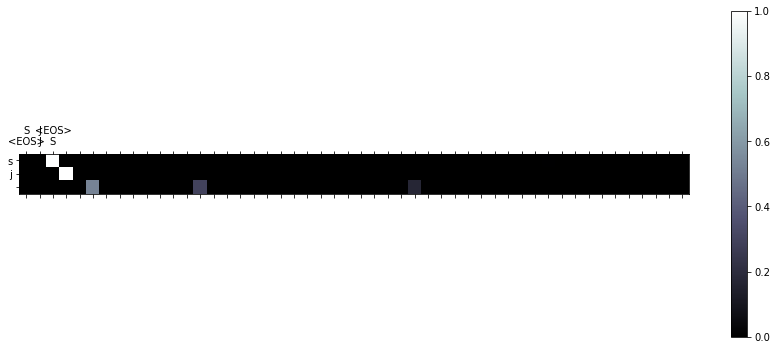

In [273]:
def debug_show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    #ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)
    
    input_sentence = input_sentence + ['<EOS>']
    inp_arr = ["{}\n{}".format(input_sentence[i], input_sentence[-1-i]) for i in range(len(input_sentence))]
    ax.set_xticklabels([''] + inp_arr, rotation=0)

    # Show label at every tick
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

    plt.show()
    
def debug_eval_sample_show_attention():
    
    sample_row = balanced_data_sample_row()
    #sample_row = balanced_data[balanced_data['before'].str.len()>15].sample(1).iloc[0]
    sample = sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence']

    output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, 
                                                            return_more=True, sample=sample)
    print('input:  ', sample[0])
    print('output: ', decoded_output)
    print('target:   ', ' '.join([words_after_common[w] for w in sample[1][:-1]]))

    attns = np.array([arr.data[0].cpu().numpy() for arr in decoder_attns_arr])

    debug_show_attention(list(sample[0]), decoded_output, attns)
    #plt.matshow(attns)

debug_eval_sample_show_attention()

In [252]:
balanced_data.groupby('class')['class'].unique()

class
ELECTRONIC    [ELECTRONIC]
LETTERS          [LETTERS]
NUMBERS          [NUMBERS]
PLAIN              [PLAIN]
VERBATIM        [VERBATIM]
Name: class, dtype: object

In [284]:
def test_in_categories(iter_len = 1000):
    wrong_preds = {}
    for cat in categories_all:
        tmp_data = sample_data[sample_data['class'] == cat].sample(iter_len)
        correct_n = 0
        wrong_preds_arr = []

        for _ in range(iter_len):
            sample_row = tmp_data.iloc[_]
            sample = sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence']

            output, t1, sample_target, t2 = test_model_single_sample(None, sample=sample)
            if output == sample_target:
                correct_n += 1
            else:
                wrong_preds_arr.append([sample_target, output])

        print("{:>10}: {:>5d}/{:>5d} ({:>4.0%})".format(cat, correct_n, iter_len, correct_n/iter_len))
        wrong_preds[cat] = wrong_preds_arr
    return wrong_preds

In [286]:
wrong_preds = test_in_categories(3000)

ELECTRONIC:   581/ 3000 ( 19%)
   LETTERS:  2885/ 3000 ( 96%)
   NUMBERS:  2768/ 3000 ( 92%)
     PLAIN:  2933/ 3000 ( 98%)
  VERBATIM:  2969/ 3000 ( 99%)


In [289]:
wrong_preds['LETTERS']

[['m e acute d o c', 'm e acute o d c'],
 ['d h a r i w a l', 'd w a w a a a l'],
 ['c i a n', 'c i a a'],
 ["u t e p's", "u t t p's"],
 ['p n h', 'p n'],
 ['h r t', 'h t t'],
 ['f c i t x', 'f x i t x'],
 ["m o g g's", 'm o g g'],
 ['k e t o s a m i n e', 'k e t e s s i i'],
 ['t k o d', 't k o k'],
 ['h u m i m p i l', 'h u m m i i i i'],
 ['o and c b', 'o and c e'],
 ['b a t t a g l i e', 'b a t t i t t e e e a'],
 ['a c n y c', 'a n n c c'],
 ['v a s s i l e v a', 'v a s s s s a a'],
 ['l y c h g a t e', 'y y g a t t t t e e'],
 ['u s c g c', 'u s s c c'],
 ['a f j r o t c', 'a j r r o t c o'],
 ['b e l o g l a z o v a', 'b o l o o a a a l l a'],
 ['d d f i o d e v i c e', 'd v v i o i i i e'],
 ['x v i i i a', 'x h i i i'],
 ['c o y g n', 'c o y g n g'],
 ["h e acute r o's", 'h e acute e acute r'],
 ['c h n m', 'c h m m'],
 ['h i r a d p a d a', 'h i p i a a d a d a'],
 ['e v', 'the'],
 ['n e w c a p', 'n e w a a p'],
 ['p d f s', 'p d f'],
 ['u s c c b', 'u s c c c'],
 ['s o c i 

In [266]:
# With training longer words
wrong_preds = test_in_categories()

ELECTRONIC:   165/  999 ( 17%)
   LETTERS:   907/  999 ( 91%)
   NUMBERS:   837/  999 ( 84%)
     PLAIN:   935/  999 ( 94%)
  VERBATIM:   986/  999 ( 99%)
